In [187]:
import os
import math
import pandas as pd
import TimeSeriesForecasters
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

def wape(y_true, y_pred):
    # Prevent from dividing by 0 like in MAPE
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

Import data

In [2]:
targets = ["Tiny+Small_+1", "Large+Mature_+1", "Tiny+Small_+2", "Large+Mature_+2", "Tiny+Small_+3", "Large+Mature_+3",
"Tiny+Small_+4", "Large+Mature_+4", "Tiny+Small_+5", "Large+Mature_+5", "Tiny+Small_+6", "Large+Mature_+6"]

In [3]:
data = pd.read_csv("../Data/prepared_data.csv")
data

,FarmID,year,month,Tiny+Small,Large+Mature,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,...,shortwave_radiation_sum,et0_fao_evapotranspiration,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
0,AG10,1998,1,43.0,13.0,34.741935,22.393548,36.770968,25.441935,0.429032,...,20.136774,4.689677,29.146371,28.788575,27.784005,26.701613,0.283711,0.301133,0.337141,0.367218
1,AG10,1998,2,28.0,28.0,35.189286,24.317857,39.117857,28.378571,1.857143,...,20.272143,4.714643,30.208780,29.864286,28.965923,27.353274,0.351561,0.334216,0.317765,0.362451
2,AG10,1998,3,13.0,43.0,35.725806,25.367742,40.496774,29.983871,1.654839,...,20.438065,4.916774,31.365054,31.121774,30.227554,28.187097,0.338056,0.309485,0.305081,0.357526
3,AG10,1998,4,11.5,38.0,33.100000,24.903333,39.120000,29.943333,4.073333,...,17.877667,4.014333,29.077639,29.184167,29.357361,28.793472,0.412431,0.368989,0.298226,0.352946
4,AG10,1998,5,10.0,33.0,32.254839,24.303226,37.919355,29.096774,2.603226,...,17.486452,3.876129,28.380780,28.423656,28.578495,28.817876,0.429190,0.411262,0.310177,0.349663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9011,MA413,2023,3,2.0,11.0,32.625806,23.593548,37.380645,27.251613,2.758065,...,19.784194,4.540323,28.529167,28.526478,28.419355,27.342876,0.390527,0.343621,0.305570,0.424620
9012,MA413,2023,4,2.0,3.0,32.833333,23.786667,37.903333,27.520000,2.563333,...,20.378667,4.632667,28.858889,28.759306,28.444028,27.731250,0.398275,0.348147,0.299015,0.413540
9013,MA413,2023,5,3.0,4.0,32.225806,24.061290,37.435484,28.312903,3.029032,...,18.983226,4.261290,28.559140,28.523656,28.383737,27.991801,0.416329,0.391871,0.301789,0.404790
9014,MA413,2023,6,1.0,1.0,29.463333,22.926667,33.333333,26.320000,6.823333,...,14.725667,3.271000,26.370000,26.618611,27.324167,27.972361,0.454496,0.444658,0.349479,0.399222


In [4]:
data_FE_FS = pd.read_csv("../Data/prepared_data_FE_FS.csv")
data_FE_FS = data_FE_FS.iloc[:, 1:].drop(columns=targets)
data_FE_FS

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,rain_sum,precipitation_hours,windgusts_10m_max,soil_moisture_28_to_100cm,...,lag_windgusts_10m_max_6,lag_windgusts_10m_max_7,lag_windgusts_10m_max_8,lag_shortwave_radiation_sum_6,lag_shortwave_radiation_sum_7,lag_soil_temperature_100_to_255cm_2,lag_soil_temperature_100_to_255cm_4,lag_soil_temperature_100_to_255cm_6,lag_soil_temperature_100_to_255cm_12,lag_soil_moisture_28_to_100cm_8
0,AG10,1999,1,8.0,5.0,35.741935,0.890323,2.741935,24.187097,0.375906,...,29.403226,26.640000,28.103226,13.650645,16.397333,26.388889,26.846806,28.154839,26.701613,0.310177
1,AG10,1999,2,6.5,11.0,36.375000,2.792857,3.571429,25.178571,0.351524,...,29.493548,29.403226,26.640000,12.649677,13.650645,26.297312,26.516667,27.409005,27.353274,0.333678
2,AG10,1999,3,5.0,17.0,37.390323,2.367742,3.645161,29.335484,0.346919,...,26.860000,29.493548,29.403226,14.029000,12.649677,26.340323,26.388889,26.846806,28.187097,0.347653
3,AG10,1999,4,18.0,14.0,37.423333,3.800000,3.433333,29.006667,0.337085,...,25.229032,26.860000,29.493548,16.064194,14.029000,26.602083,26.297312,26.516667,28.793472,0.368558
4,AG10,1999,5,31.0,11.0,36.832258,2.822581,4.193548,27.741935,0.333712,...,26.223333,25.229032,26.860000,14.828667,16.064194,26.849194,26.340323,26.388889,28.817876,0.391887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8591,MA413,2022,9,4.0,45.0,32.260000,7.030000,13.200000,26.163333,0.493833,...,27.680645,28.478571,25.693548,19.948065,20.812857,27.298790,28.284005,28.228629,26.359583,0.331667
8592,MA413,2022,10,2.0,37.0,34.119355,4.745161,9.290323,25.064516,0.489003,...,27.836667,27.680645,28.478571,19.645000,19.948065,26.541532,27.928056,28.400000,26.120296,0.309576
8593,MA413,2022,11,5.0,17.0,34.520000,1.643333,4.833333,25.740000,0.430129,...,23.700000,27.836667,27.680645,17.290323,19.645000,26.003333,27.298790,28.284005,26.103889,0.300792
8594,MA413,2022,12,15.0,10.0,34.325806,0.596774,1.516129,24.935484,0.381405,...,26.046667,23.700000,27.836667,17.048667,17.290323,25.693817,26.541532,27.928056,26.349597,0.304969


CatBoost

In [5]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for category in data_FE_FS["FarmID"].unique():
    train_data = train_data.append(data_FE_FS[data_FE_FS["FarmID"] == category].iloc[:-7, :], ignore_index=True)
    test_data = test_data.append(data_FE_FS[data_FE_FS["FarmID"] == category].iloc[-7, :], ignore_index=True)

# train = data_FE_FS.iloc[:-1, :]
# test = data_FE_FS.tail(1)

In [6]:
train_data

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,rain_sum,precipitation_hours,windgusts_10m_max,soil_moisture_28_to_100cm,...,lag_windgusts_10m_max_6,lag_windgusts_10m_max_7,lag_windgusts_10m_max_8,lag_shortwave_radiation_sum_6,lag_shortwave_radiation_sum_7,lag_soil_temperature_100_to_255cm_2,lag_soil_temperature_100_to_255cm_4,lag_soil_temperature_100_to_255cm_6,lag_soil_temperature_100_to_255cm_12,lag_soil_moisture_28_to_100cm_8
0,AG10,1999,1,8.0,5.0,35.741935,0.890323,2.741935,24.187097,0.375906,...,29.403226,26.640000,28.103226,13.650645,16.397333,26.388889,26.846806,28.154839,26.701613,0.310177
1,AG10,1999,2,6.5,11.0,36.375000,2.792857,3.571429,25.178571,0.351524,...,29.493548,29.403226,26.640000,12.649677,13.650645,26.297312,26.516667,27.409005,27.353274,0.333678
2,AG10,1999,3,5.0,17.0,37.390323,2.367742,3.645161,29.335484,0.346919,...,26.860000,29.493548,29.403226,14.029000,12.649677,26.340323,26.388889,26.846806,28.187097,0.347653
3,AG10,1999,4,18.0,14.0,37.423333,3.800000,3.433333,29.006667,0.337085,...,25.229032,26.860000,29.493548,16.064194,14.029000,26.602083,26.297312,26.516667,28.793472,0.368558
4,AG10,1999,5,31.0,11.0,36.832258,2.822581,4.193548,27.741935,0.333712,...,26.223333,25.229032,26.860000,14.828667,16.064194,26.849194,26.340323,26.388889,28.817876,0.391887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8115,MA413,2022,2,14.0,11.0,37.707143,0.625000,1.392857,28.478571,0.309576,...,28.561290,27.054839,26.663333,14.490968,13.896774,26.349597,26.120296,26.802016,27.129167,0.337283
8116,MA413,2022,3,8.0,24.0,38.119355,2.606452,4.193548,27.680645,0.300792,...,25.750000,28.561290,27.054839,16.060000,14.490968,26.988441,26.103889,26.359583,27.718952,0.407462
8117,MA413,2022,4,2.0,27.0,36.810000,3.473333,3.733333,27.836667,0.304969,...,25.038710,25.750000,28.561290,17.600645,16.060000,27.645982,26.349597,26.120296,27.873194,0.477562
8118,MA413,2022,5,11.0,18.0,35.645161,4.309677,7.387097,23.700000,0.314966,...,27.013333,25.038710,25.750000,17.950000,17.600645,28.228629,26.988441,26.103889,28.000000,0.499056


In [7]:
test_data

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,rain_sum,precipitation_hours,windgusts_10m_max,soil_moisture_28_to_100cm,...,lag_windgusts_10m_max_6,lag_windgusts_10m_max_7,lag_windgusts_10m_max_8,lag_shortwave_radiation_sum_6,lag_shortwave_radiation_sum_7,lag_soil_temperature_100_to_255cm_2,lag_soil_temperature_100_to_255cm_4,lag_soil_temperature_100_to_255cm_6,lag_soil_temperature_100_to_255cm_12,lag_soil_moisture_28_to_100cm_8
0,AG10,2022,7,147.0,38.0,32.074194,1.306452,6.193548,27.664516,0.410858,...,24.187097,23.961290,25.696667,21.135161,19.111613,29.082930,28.783737,27.644489,28.284946,0.421354
1,AG11,2022,7,72.0,7.0,31.851613,1.332258,5.903226,28.000000,0.376379,...,24.529032,24.374194,25.863333,21.250645,19.200323,28.030242,27.750806,26.937769,27.132661,0.369733
2,DA4,2022,7,15.0,28.0,31.677419,1.448387,5.741935,27.154839,0.351288,...,24.877419,25.722581,28.050000,20.160000,18.539677,27.333333,27.404973,26.473387,26.380914,0.365150
3,SP23,2022,7,122.0,64.0,30.951613,2.019355,7.838710,31.506452,0.382509,...,28.119355,26.590323,28.193333,19.440000,17.627419,26.852151,26.798253,26.177419,25.836425,0.367250
4,GA20,2022,7,34.0,72.0,31.787097,1.525806,5.258065,27.554839,0.380763,...,25.719355,25.851613,28.383333,20.301613,18.764194,27.525941,27.464919,26.498387,26.511559,0.412429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,MA405,2022,7,27.0,41.0,31.535484,2.041935,8.806452,28.287097,0.438581,...,27.596774,26.580645,28.963333,21.349677,19.785161,28.676613,28.527554,27.312769,27.984812,0.432415
64,MA401,2022,7,79.0,30.0,30.906452,3.454839,10.064516,25.158065,0.472297,...,26.919355,26.248387,27.246667,20.683226,18.896129,28.011290,27.941935,26.781989,26.940591,0.401996
65,MA402,2022,7,68.0,8.0,31.212903,3.454839,10.064516,25.158065,0.472297,...,26.919355,26.248387,27.246667,20.683226,18.896129,28.211290,28.141935,26.981989,27.140591,0.401996
66,MA412,2022,7,90.0,64.0,30.612903,2.029032,9.516129,25.293548,0.456733,...,25.693548,25.622581,27.013333,20.905161,19.171613,28.174194,28.063441,26.825806,27.399597,0.422078


In [8]:
params = {
          'loss_function': 'MultiRMSE',
          'eval_metric': 'MultiRMSE'
         }
catBoostTimeSeriesForecaster = TimeSeriesForecasters.RegressionTimeSeriesForecaster(CatBoostRegressor(**params))

In [9]:
catBoostTimeSeriesForecaster = TimeSeriesForecasters.RegressionTimeSeriesForecaster(CatBoostRegressor().load_model("Cat_Boost_Global"))

In [9]:
catBoostTimeSeriesForecaster.prepare_data(train_data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)
catBoostTimeSeriesForecaster.data

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,rain_sum,precipitation_hours,windgusts_10m_max,soil_moisture_28_to_100cm,...,Tiny+Small_+3,Tiny+Small_+4,Tiny+Small_+5,Tiny+Small_+6,Large+Mature_+1,Large+Mature_+2,Large+Mature_+3,Large+Mature_+4,Large+Mature_+5,Large+Mature_+6
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-01,AG10,1999,1,8.0,5.0,35.741935,0.890323,2.741935,24.187097,0.375906,...,18.0,31.0,78.0,70.000000,11.0,17.0,14.0,11.0,36.0,69.000000
1999-02-01,AG10,1999,2,6.5,11.0,36.375000,2.792857,3.571429,25.178571,0.351524,...,31.0,78.0,70.0,57.500000,17.0,14.0,11.0,36.0,69.0,86.500000
1999-03-01,AG10,1999,3,5.0,17.0,37.390323,2.367742,3.645161,29.335484,0.346919,...,78.0,70.0,57.5,45.000000,14.0,11.0,36.0,69.0,86.5,104.000000
1999-04-01,AG10,1999,4,18.0,14.0,37.423333,3.800000,3.433333,29.006667,0.337085,...,70.0,57.5,45.0,10.000000,11.0,36.0,69.0,86.5,104.0,72.000000
1999-05-01,AG10,1999,5,31.0,11.0,36.832258,2.822581,4.193548,27.741935,0.333712,...,57.5,45.0,10.0,9.333333,36.0,69.0,86.5,104.0,72.0,53.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,MA413,2021,8,30.0,13.0,31.654839,8.945161,8.741935,28.561290,0.477562,...,11.0,18.0,12.0,14.000000,42.0,55.0,46.0,22.0,16.0,11.000000
2021-09-01,MA413,2021,9,37.0,42.0,33.570000,8.563333,9.600000,25.750000,0.499056,...,18.0,12.0,14.0,8.000000,55.0,46.0,22.0,16.0,11.0,24.000000
2021-10-01,MA413,2021,10,36.0,55.0,34.961290,2.674194,5.645161,25.038710,0.468228,...,12.0,14.0,8.0,2.000000,46.0,22.0,16.0,11.0,24.0,27.000000


In [10]:
catBoostTimeSeriesForecaster.train_model(catBoostTimeSeriesForecaster.data)

0:	learn: 133.7593121	total: 220ms	remaining: 3m 39s
1:	learn: 132.8542400	total: 304ms	remaining: 2m 31s
2:	learn: 132.0500906	total: 388ms	remaining: 2m 8s
3:	learn: 131.1908538	total: 480ms	remaining: 1m 59s
4:	learn: 130.4276568	total: 579ms	remaining: 1m 55s
5:	learn: 129.6633149	total: 677ms	remaining: 1m 52s
6:	learn: 128.8528596	total: 776ms	remaining: 1m 50s
7:	learn: 128.1704469	total: 872ms	remaining: 1m 48s
8:	learn: 127.4559929	total: 960ms	remaining: 1m 45s
9:	learn: 126.7338800	total: 1.05s	remaining: 1m 44s
10:	learn: 126.0509573	total: 1.16s	remaining: 1m 44s
11:	learn: 125.4028358	total: 1.27s	remaining: 1m 44s
12:	learn: 124.7537667	total: 1.38s	remaining: 1m 45s
13:	learn: 124.1213023	total: 1.49s	remaining: 1m 45s
14:	learn: 123.4853957	total: 1.6s	remaining: 1m 45s
15:	learn: 122.8492754	total: 1.71s	remaining: 1m 45s
16:	learn: 122.3430361	total: 1.82s	remaining: 1m 45s
17:	learn: 121.7622813	total: 1.92s	remaining: 1m 44s
18:	learn: 121.2834524	total: 2.02s	rema

In [11]:
catBoostTimeSeriesForecaster.save_model().save_model("Cat_Boost_Global")

In [12]:
test_data["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in test_data.iterrows()]
test_data["Date"] = pd.to_datetime(test_data["Date"])
test_data.index = test_data["Date"]
test_data.drop(columns=["Date"], inplace=True)
test_data["FarmID"] = test_data["FarmID"].astype("category")

In [13]:
test_data

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,rain_sum,precipitation_hours,windgusts_10m_max,soil_moisture_28_to_100cm,...,lag_windgusts_10m_max_6,lag_windgusts_10m_max_7,lag_windgusts_10m_max_8,lag_shortwave_radiation_sum_6,lag_shortwave_radiation_sum_7,lag_soil_temperature_100_to_255cm_2,lag_soil_temperature_100_to_255cm_4,lag_soil_temperature_100_to_255cm_6,lag_soil_temperature_100_to_255cm_12,lag_soil_moisture_28_to_100cm_8
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,AG10,2022,7,147.0,38.0,32.074194,1.306452,6.193548,27.664516,0.410858,...,24.187097,23.961290,25.696667,21.135161,19.111613,29.082930,28.783737,27.644489,28.284946,0.421354
2022-07-01,AG11,2022,7,72.0,7.0,31.851613,1.332258,5.903226,28.000000,0.376379,...,24.529032,24.374194,25.863333,21.250645,19.200323,28.030242,27.750806,26.937769,27.132661,0.369733
2022-07-01,DA4,2022,7,15.0,28.0,31.677419,1.448387,5.741935,27.154839,0.351288,...,24.877419,25.722581,28.050000,20.160000,18.539677,27.333333,27.404973,26.473387,26.380914,0.365150
2022-07-01,SP23,2022,7,122.0,64.0,30.951613,2.019355,7.838710,31.506452,0.382509,...,28.119355,26.590323,28.193333,19.440000,17.627419,26.852151,26.798253,26.177419,25.836425,0.367250
2022-07-01,GA20,2022,7,34.0,72.0,31.787097,1.525806,5.258065,27.554839,0.380763,...,25.719355,25.851613,28.383333,20.301613,18.764194,27.525941,27.464919,26.498387,26.511559,0.412429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,MA405,2022,7,27.0,41.0,31.535484,2.041935,8.806452,28.287097,0.438581,...,27.596774,26.580645,28.963333,21.349677,19.785161,28.676613,28.527554,27.312769,27.984812,0.432415
2022-07-01,MA401,2022,7,79.0,30.0,30.906452,3.454839,10.064516,25.158065,0.472297,...,26.919355,26.248387,27.246667,20.683226,18.896129,28.011290,27.941935,26.781989,26.940591,0.401996
2022-07-01,MA402,2022,7,68.0,8.0,31.212903,3.454839,10.064516,25.158065,0.472297,...,26.919355,26.248387,27.246667,20.683226,18.896129,28.211290,28.141935,26.981989,27.140591,0.401996


In [14]:
preds = catBoostTimeSeriesForecaster.predict(test_data)

In [15]:
preds

,FarmID,year,month,Tiny+Small_+1_pred,Tiny+Small_+2_pred,Tiny+Small_+3_pred,Tiny+Small_+4_pred,Tiny+Small_+5_pred,Tiny+Small_+6_pred,Large+Mature_+1_pred,Large+Mature_+2_pred,Large+Mature_+3_pred,Large+Mature_+4_pred,Large+Mature_+5_pred,Large+Mature_+6_pred
Date,,,,,,,,,,,,,,,
2022-07-01,AG10,2022,7,94.250768,43.702333,27.297711,33.512430,38.370126,35.652364,89.344865,107.686385,85.402412,53.740882,34.661121,34.654845
2022-07-01,AG11,2022,7,58.069272,34.520327,24.626963,28.528134,31.996261,29.542416,49.239133,65.204438,57.799046,38.446280,25.447107,26.020928
2022-07-01,DA4,2022,7,9.072434,6.267581,9.268530,12.700953,12.621132,11.138488,28.942919,22.751374,14.082482,10.667935,10.219573,11.789093
2022-07-01,SP23,2022,7,58.877363,25.025640,26.122652,37.759074,43.969996,35.495612,100.241422,83.910454,50.921818,25.311993,16.982245,23.412375
2022-07-01,GA20,2022,7,20.962223,15.779857,21.092593,26.163706,24.289937,18.204412,70.364334,55.030466,37.635921,29.333775,28.899759,30.841253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,MA405,2022,7,32.832976,40.024799,45.992241,46.155187,40.134966,31.467990,43.704429,48.023201,51.258969,54.363921,57.462746,58.358135
2022-07-01,MA401,2022,7,68.932935,48.789095,39.200012,42.140048,42.493731,32.757259,57.434372,74.643791,69.702410,55.966965,44.260311,44.125308
2022-07-01,MA402,2022,7,75.640636,57.104860,41.600149,37.937875,35.370371,28.985425,35.326057,58.647018,67.614973,59.885373,46.305305,39.504381


In [16]:
preds_pivoted = {"FarmID": [], "year": [], "month": [], "Tiny+Small_pred": [], "Large+Mature_pred": []}
targets = {"Tiny+Small": ["Tiny+Small_+1_pred", "Tiny+Small_+2_pred", "Tiny+Small_+3_pred", "Tiny+Small_+4_pred", "Tiny+Small_+5_pred", "Tiny+Small_+6_pred"], 
"Large+Mature": ["Large+Mature_+1_pred", "Large+Mature_+2_pred", "Large+Mature_+3_pred", "Large+Mature_+4_pred", "Large+Mature_+5_pred", "Large+Mature_+6_pred"]}
for farmid in preds["FarmID"].unique():
    for i, (target_small, target_large) in enumerate(zip(targets["Tiny+Small"], targets["Large+Mature"])):
        preds_pivoted["FarmID"].append(farmid)
        if preds[preds["FarmID"] == farmid]["month"].values[0] + (i+1) > 12:
            preds_pivoted["month"].append(preds[preds["FarmID"] == farmid]["month"].values[0] + (i+1) - 12)
            preds_pivoted["year"].append(preds[preds["FarmID"] == farmid]["year"].values[0] + 1)
        else:
            preds_pivoted["month"].append(preds[preds["FarmID"] == farmid]["month"].values[0] + (i+1))
            preds_pivoted["year"].append(preds[preds["FarmID"] == farmid]["year"].values[0])
        preds_pivoted["Tiny+Small_pred"].append(preds[preds["FarmID"] == farmid][target_small].values[0])
        preds_pivoted["Large+Mature_pred"].append(preds[preds["FarmID"] == farmid][target_large].values[0])
    # preds_pivoted["FarmID"] = farmid
    # preds[preds]

In [17]:
tbl_preds_pivoted = pd.DataFrame(preds_pivoted)

In [18]:
tbl_preds_pivoted["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in tbl_preds_pivoted.iterrows()]
tbl_preds_pivoted["Date"] = pd.to_datetime(tbl_preds_pivoted["Date"])
tbl_preds_pivoted.index = tbl_preds_pivoted["Date"]
tbl_preds_pivoted.drop(columns=["Date"], inplace=True)

In [19]:
tbl_preds_grouped = tbl_preds_pivoted.groupby("Date")[["Tiny+Small_pred", "Large+Mature_pred"]].sum()

In [20]:
pd.DataFrame(preds_pivoted)[pd.DataFrame(preds_pivoted)["FarmID"] == "AG10"]

,FarmID,year,month,Tiny+Small_pred,Large+Mature_pred
0,AG10,2022,8,94.250768,89.344865
1,AG10,2022,9,43.702333,107.686385
2,AG10,2022,10,27.297711,85.402412
3,AG10,2022,11,33.512430,53.740882
4,AG10,2022,12,38.370126,34.661121
5,AG10,2023,1,35.652364,34.654845


In [21]:
comparison_data = pd.DataFrame()
for category in data_FE_FS["FarmID"].unique():
    comparison_data = comparison_data.append(data_FE_FS[data_FE_FS["FarmID"] == category].tail(6))

In [22]:
comparison_data

,FarmID,year,month,Tiny+Small,Large+Mature,apparent_temperature_max,rain_sum,precipitation_hours,windgusts_10m_max,soil_moisture_28_to_100cm,...,lag_windgusts_10m_max_6,lag_windgusts_10m_max_7,lag_windgusts_10m_max_8,lag_shortwave_radiation_sum_6,lag_shortwave_radiation_sum_7,lag_soil_temperature_100_to_255cm_2,lag_soil_temperature_100_to_255cm_4,lag_soil_temperature_100_to_255cm_6,lag_soil_temperature_100_to_255cm_12,lag_soil_moisture_28_to_100cm_8
283,AG10,2022,8,96.0,80.0,31.522581,3.222581,8.516129,30.067742,0.392913,...,27.450000,24.187097,23.961290,19.697143,21.135161,28.632361,29.132639,28.233333,27.621640,0.379274
284,AG10,2022,9,9.0,43.0,32.990000,3.830000,10.233333,26.480000,0.423176,...,28.677419,27.450000,24.187097,20.172258,19.697143,27.909409,29.082930,28.783737,27.150556,0.339082
285,AG10,2022,10,4.0,33.0,35.835484,4.848387,8.580645,25.441935,0.472117,...,27.813333,28.677419,27.450000,19.997000,20.172258,27.326882,28.632361,29.132639,26.886828,0.316713
286,AG10,2022,11,17.0,22.0,35.856667,0.726667,3.600000,23.593333,0.433872,...,26.116129,27.813333,28.677419,17.162258,19.997000,26.875833,27.909409,29.082930,26.823611,0.304206
287,AG10,2022,12,43.0,18.0,35.632258,0.390323,1.322581,22.354839,0.379598,...,25.503333,26.116129,27.813333,15.426333,17.162258,26.499194,27.326882,28.632361,27.064382,0.296114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8591,MA413,2022,9,4.0,45.0,32.260000,7.030000,13.200000,26.163333,0.493833,...,27.680645,28.478571,25.693548,19.948065,20.812857,27.298790,28.284005,28.228629,26.359583,0.331667
8592,MA413,2022,10,2.0,37.0,34.119355,4.745161,9.290323,25.064516,0.489003,...,27.836667,27.680645,28.478571,19.645000,19.948065,26.541532,27.928056,28.400000,26.120296,0.309576
8593,MA413,2022,11,5.0,17.0,34.520000,1.643333,4.833333,25.740000,0.430129,...,23.700000,27.836667,27.680645,17.290323,19.645000,26.003333,27.298790,28.284005,26.103889,0.300792
8594,MA413,2022,12,15.0,10.0,34.325806,0.596774,1.516129,24.935484,0.381405,...,26.046667,23.700000,27.836667,17.048667,17.290323,25.693817,26.541532,27.928056,26.349597,0.304969


In [23]:
comparison_data["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in comparison_data.iterrows()]
comparison_data["Date"] = pd.to_datetime(comparison_data["Date"])
comparison_data.index = comparison_data["Date"]
comparison_data.drop(columns=["Date"], inplace=True)

In [24]:
comparison_data_grouped = comparison_data.groupby("Date")[["Tiny+Small", "Large+Mature"]].sum()
comparison_data_grouped["Tiny+Small_pred"] = tbl_preds_grouped["Tiny+Small_pred"]
comparison_data_grouped["Large+Mature_pred"] = tbl_preds_grouped["Large+Mature_pred"]

<Axes: xlabel='Date'>

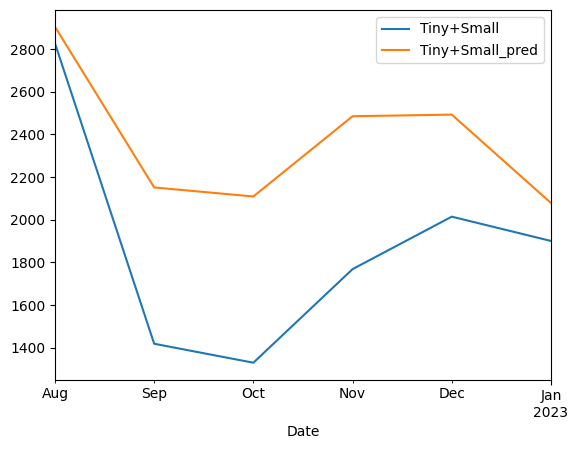

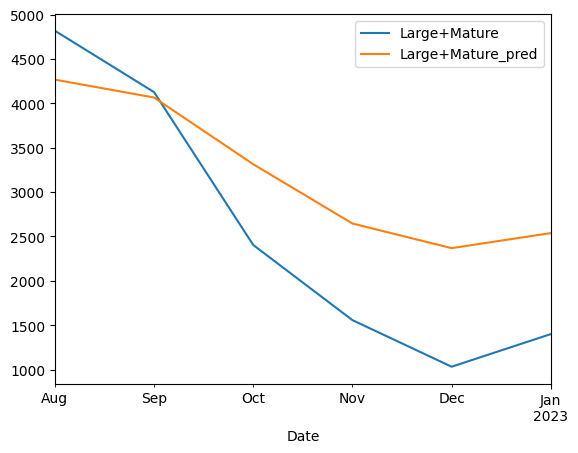

In [25]:
comparison_data_grouped[["Tiny+Small", "Tiny+Small_pred"]].plot()
comparison_data_grouped[["Large+Mature", "Large+Mature_pred"]].plot()

In [42]:
comparison_data_grouped

,Tiny+Small,Large+Mature,Tiny+Small_pred,Large+Mature_pred
Date,,,,
2022-08-01,2827.0,4819.0,2904.733015,4267.919597
2022-09-01,1418.0,4127.0,2150.980207,4066.191945
2022-10-01,1329.0,2404.0,2108.614687,3314.275993
2022-11-01,1768.0,1557.0,2484.978973,2646.099469
2022-12-01,2014.0,1032.0,2492.506190,2368.504575
2023-01-01,1900.0,1400.0,2078.028262,2538.125992


Auto-arima

In [26]:
import pmdarima as pm

In [27]:
stat_data = data[["FarmID", "year", "month", "Tiny+Small", "Large+Mature"]]

In [28]:
stat_data["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in stat_data.iterrows()]
stat_data["Date"] = pd.to_datetime(stat_data["Date"])
stat_data.index = stat_data["Date"]
stat_data.drop(columns=["Date"], inplace=True)

In [29]:
stat_data_grouped = stat_data.groupby("Date")[["Tiny+Small", "Large+Mature"]].sum()

In [30]:
stat_data_grouped["year"] = stat_data_grouped.index.year
stat_data_grouped["month"] = stat_data_grouped.index.month

In [31]:
stat_data_grouped = stat_data_grouped.reset_index().drop(columns=["Date"])

In [32]:
stat_data_grouped.iloc[:-6, :]

,Tiny+Small,Large+Mature,year,month
0,170.0,58.0,1998,1
1,96.0,98.0,1998,2
2,22.0,138.0,1998,3
3,101.0,94.0,1998,4
4,180.0,50.0,1998,5
...,...,...,...,...
296,1418.0,4127.0,2022,9
297,1329.0,2404.0,2022,10
298,1768.0,1557.0,2022,11
299,2014.0,1032.0,2022,12


In [33]:
arima_test = stat_data_grouped.iloc[:-6, :].tail(6)
arima_train = stat_data_grouped.iloc[:-6, :].iloc[:-6, :]

In [34]:
arima_train

,Tiny+Small,Large+Mature,year,month
0,170.0,58.0,1998,1
1,96.0,98.0,1998,2
2,22.0,138.0,1998,3
3,101.0,94.0,1998,4
4,180.0,50.0,1998,5
...,...,...,...,...
290,901.0,2174.0,2022,3
291,1514.0,1566.0,2022,4
292,3217.0,1258.0,2022,5
293,4728.0,1395.0,2022,6


In [35]:
arima_test

,Tiny+Small,Large+Mature,year,month
295,2827.0,4819.0,2022,8
296,1418.0,4127.0,2022,9
297,1329.0,2404.0,2022,10
298,1768.0,1557.0,2022,11
299,2014.0,1032.0,2022,12
300,1900.0,1400.0,2023,1


In [36]:
all_preds = pd.DataFrame()
for target in ["Tiny+Small", "Large+Mature"]:
    #Standard ARIMA Model
    model = pm.auto_arima(arima_train[target], 
                        m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                        seasonal=True)
    
    preds = model.predict(arima_test[target].shape[0])
    all_preds[f"{target}_pred"] = preds

In [37]:
arima_test["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in arima_test.iterrows()]
arima_test["Date"] = pd.to_datetime(arima_test["Date"])
arima_test.index = arima_test["Date"]
arima_test.drop(columns=["Date"], inplace=True)

In [38]:
arima_test["Tiny+Small_pred"] = all_preds["Tiny+Small_pred"].values
arima_test["Large+Mature_pred"] = all_preds["Large+Mature_pred"].values

In [39]:
arima_test

,Tiny+Small,Large+Mature,year,month,Tiny+Small_pred,Large+Mature_pred
Date,,,,,,
2022-08-01,2827.0,4819.0,2022,8,2601.793486,4170.501337
2022-09-01,1418.0,4127.0,2022,9,1660.407242,3715.721434
2022-10-01,1329.0,2404.0,2022,10,1882.042507,2696.268355
2022-11-01,1768.0,1557.0,2022,11,2531.568546,2077.377778
2022-12-01,2014.0,1032.0,2022,12,2562.684459,2003.971014
2023-01-01,1900.0,1400.0,2023,1,2286.356508,2416.041517


In [40]:
comparison_data_grouped

,Tiny+Small,Large+Mature,Tiny+Small_pred,Large+Mature_pred
Date,,,,
2022-08-01,2827.0,4819.0,2904.733015,4267.919597
2022-09-01,1418.0,4127.0,2150.980207,4066.191945
2022-10-01,1329.0,2404.0,2108.614687,3314.275993
2022-11-01,1768.0,1557.0,2484.978973,2646.099469
2022-12-01,2014.0,1032.0,2492.506190,2368.504575
2023-01-01,1900.0,1400.0,2078.028262,2538.125992


<Axes: xlabel='Date'>

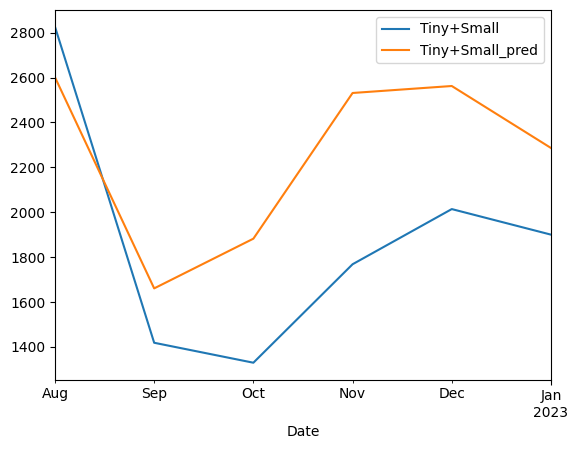

In [41]:
arima_test[["Tiny+Small", "Tiny+Small_pred"]].plot()

<Axes: xlabel='Date'>

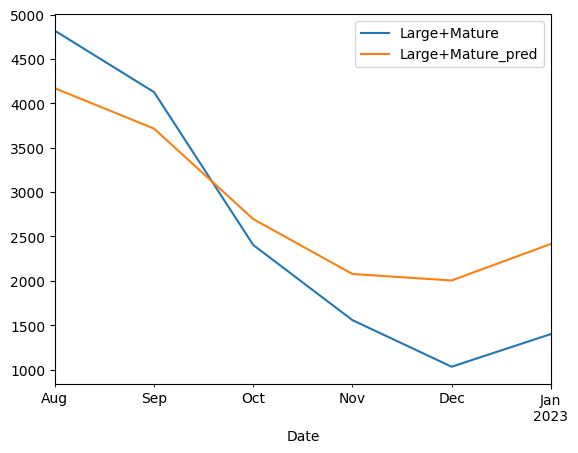

In [96]:
arima_test[["Large+Mature", "Large+Mature_pred"]].plot()

In [43]:
comparison_data_grouped["arima_Tiny+Small_pred"] = arima_test["Tiny+Small_pred"]
comparison_data_grouped["arima_Large+Mature_pred"] = arima_test["Large+Mature_pred"]

In [44]:
comparison_data_grouped

,Tiny+Small,Large+Mature,Tiny+Small_pred,Large+Mature_pred,arima_Tiny+Small_pred,arima_Large+Mature_pred
Date,,,,,,
2022-08-01,2827.0,4819.0,2904.733015,4267.919597,2601.793486,4170.501337
2022-09-01,1418.0,4127.0,2150.980207,4066.191945,1660.407242,3715.721434
2022-10-01,1329.0,2404.0,2108.614687,3314.275993,1882.042507,2696.268355
2022-11-01,1768.0,1557.0,2484.978973,2646.099469,2531.568546,2077.377778
2022-12-01,2014.0,1032.0,2492.506190,2368.504575,2562.684459,2003.971014
2023-01-01,1900.0,1400.0,2078.028262,2538.125992,2286.356508,2416.041517


In [47]:
training_data = stat_data_grouped.iloc[:-6, :].iloc[:-6, :]

In [48]:
training_data["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in training_data.iterrows()]
training_data["Date"] = pd.to_datetime(training_data["Date"])
training_data.index = training_data["Date"]
training_data.drop(columns=["Date"], inplace=True)

In [80]:
training_data_new = training_data.copy()
training_data_new["Tiny+Small"] = (training_data_new["Tiny+Small"] - training_data_new["Tiny+Small"].mean()) / training_data_new["Tiny+Small"].std()
training_data_new["Large+Mature"] = (training_data_new["Large+Mature"] - training_data_new["Large+Mature"].mean()) / training_data_new["Large+Mature"].std()

In [81]:
training_data_new

,Tiny+Small,Large+Mature,year,month
Date,,,,
1998-01-01,-0.830424,-0.907370,1998,1
1998-02-01,-0.902729,-0.867329,1998,2
1998-03-01,-0.975034,-0.827288,1998,3
1998-04-01,-0.897843,-0.871333,1998,4
1998-05-01,-0.820653,-0.915378,1998,5
...,...,...,...,...
2022-03-01,-0.116165,1.210799,2022,3
2022-04-01,0.482795,0.602176,2022,4
2022-05-01,2.146792,0.293860,2022,5


In [119]:
from textwrap import wrap

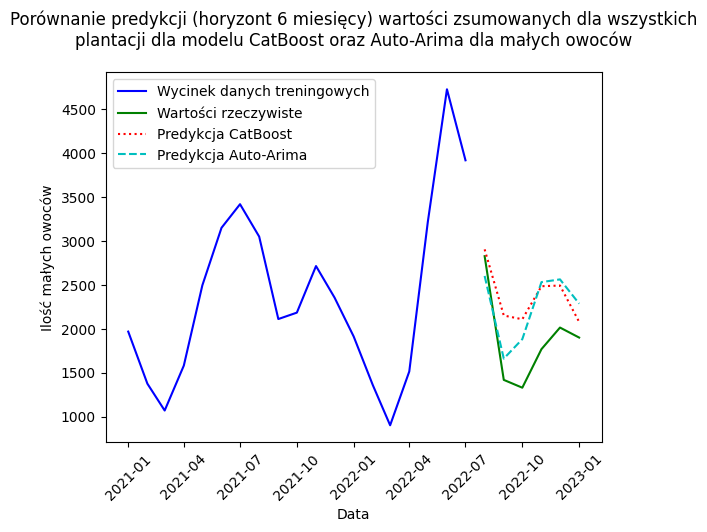

In [135]:
plt.plot(training_data[training_data.index > "2020-12-01"]["Tiny+Small"], 'b', label="Wycinek danych treningowych")
plt.plot(comparison_data_grouped["Tiny+Small"], 'g-', label = "Wartości rzeczywiste")
plt.plot(comparison_data_grouped["Tiny+Small_pred"], 'r:', label = "Predykcja CatBoost")
plt.plot(comparison_data_grouped["arima_Tiny+Small_pred"], 'c--', label = "Predykcja Auto-Arima")
plt.title("\n".join(wrap("Porównanie predykcji (horyzont 6 miesięcy) wartości zsumowanych dla wszystkich plantacji dla modelu CatBoost oraz Auto-Arima dla małych owoców", 80)), y=1.05)
plt.xticks(rotation = 45)
plt.xlabel("Data")
plt.ylabel("Ilość małych owoców")
plt.legend()
plt.show()

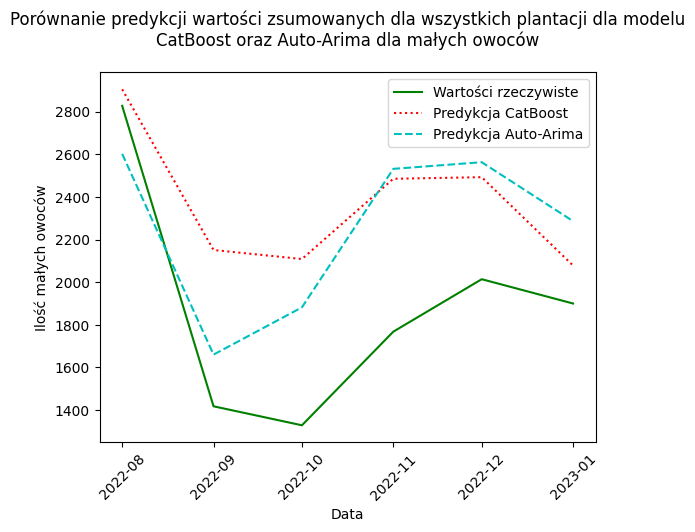

In [134]:
# plt.plot(training_data[training_data.index > "2020-12-01"]["Tiny+Small"], 'b', label="Wycinek danych treningowych")
plt.plot(comparison_data_grouped["Tiny+Small"], 'g-', label = "Wartości rzeczywiste")
plt.plot(comparison_data_grouped["Tiny+Small_pred"], 'r:', label = "Predykcja CatBoost")
plt.plot(comparison_data_grouped["arima_Tiny+Small_pred"], 'c--', label = "Predykcja Auto-Arima")
plt.title("\n".join(wrap("Porównanie predykcji wartości (horyzont 6 miesięcy) zsumowanych dla wszystkich plantacji dla modelu CatBoost oraz Auto-Arima dla małych owoców", 80)), y=1.05)
plt.xticks(rotation = 45)
plt.xlabel("Data")
plt.ylabel("Ilość małych owoców")
plt.legend()
plt.show()

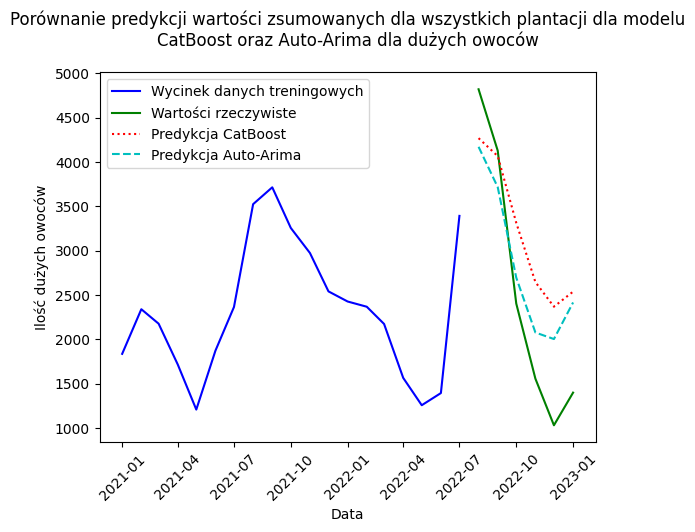

In [131]:
plt.plot(training_data[training_data.index > "2020-12-01"]["Large+Mature"], 'b', label="Wycinek danych treningowych")
plt.plot(comparison_data_grouped["Large+Mature"], 'g-', label = "Wartości rzeczywiste")
plt.plot(comparison_data_grouped["Large+Mature_pred"], 'r:', label = "Predykcja CatBoost")
plt.plot(comparison_data_grouped["arima_Large+Mature_pred"], 'c--', label = "Predykcja Auto-Arima")
plt.title("\n".join(wrap("Porównanie predykcji wartości (horyzont 6 miesięcy) zsumowanych dla wszystkich plantacji dla modelu CatBoost oraz Auto-Arima dla dużych owoców", 80)), y=1.05)
plt.xticks(rotation = 45)
plt.xlabel("Data")
plt.ylabel("Ilość dużych owoców")
plt.legend()
plt.show()

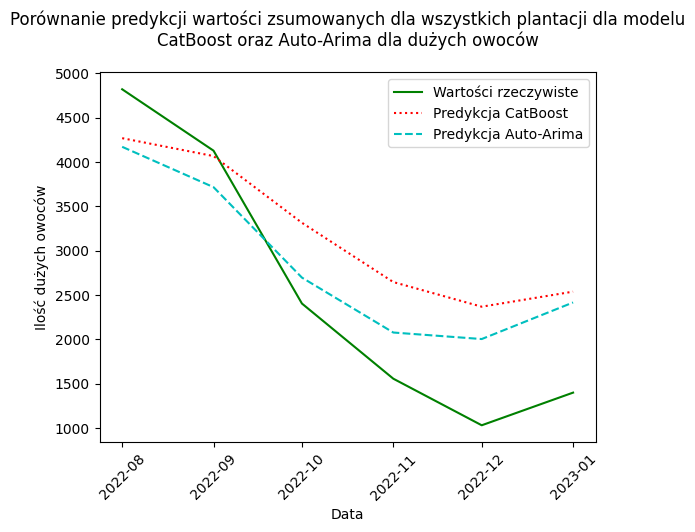

In [132]:
# plt.plot(training_data[training_data.index > "2020-12-01"]["Large+Mature"])
plt.plot(comparison_data_grouped["Large+Mature"], 'g-', label = "Wartości rzeczywiste")
plt.plot(comparison_data_grouped["Large+Mature_pred"], 'r:', label = "Predykcja CatBoost")
plt.plot(comparison_data_grouped["arima_Large+Mature_pred"], 'c--', label = "Predykcja Auto-Arima")
plt.title("\n".join(wrap("Porównanie predykcji wartości (horyzont 6 miesięcy) zsumowanych dla wszystkich plantacji dla modelu CatBoost oraz Auto-Arima dla dużych owoców", 80)), y=1.05)
plt.xticks(rotation = 45)
plt.xlabel("Data")
plt.ylabel("Ilość dużych owoców")
plt.legend()
plt.show()

In [84]:
comparison_data_grouped.drop(columns=["catboost_error_Tiny+Small", "catboost_error_Large+Mature", "arima_error_Tiny+Small", "arima_error_Large+Mature"], inplace=True)

In [87]:
(comparison_data_grouped["Large+Mature"] - comparison_data_grouped["Large+Mature"].mean()) / comparison_data_grouped["Large+Mature"].std()

Date
2022-08-01    1.444325
2022-09-01    1.002569
2022-10-01   -0.097352
2022-11-01   -0.638057
2022-12-01   -0.973204
2023-01-01   -0.738282
Name: Large+Mature, dtype: float64

In [149]:
comparison_data_grouped["catboost_error_Tiny+Small"] = abs(comparison_data_grouped["Tiny+Small"].values - comparison_data_grouped["Tiny+Small_pred"].values)
comparison_data_grouped["catboost_error_Large+Mature"] = abs(comparison_data_grouped["Large+Mature"].values - comparison_data_grouped["Large+Mature_pred"].values)
comparison_data_grouped["arima_error_Tiny+Small"] = abs(comparison_data_grouped["Tiny+Small"].values - comparison_data_grouped["arima_Tiny+Small_pred"].values)
comparison_data_grouped["arima_error_Large+Mature"] = abs(comparison_data_grouped["Large+Mature"].values - comparison_data_grouped["arima_Large+Mature_pred"].values)

In [150]:
comparison_data_grouped

,Tiny+Small,Large+Mature,Tiny+Small_pred,Large+Mature_pred,arima_Tiny+Small_pred,arima_Large+Mature_pred,catboost_error_Tiny+Small,catboost_error_Large+Mature,arima_error_Tiny+Small,arima_error_Large+Mature
Date,,,,,,,,,,
2022-08-01,2827.0,4819.0,2904.733015,4267.919597,2601.793486,4170.501337,77.733015,551.080403,225.206514,648.498663
2022-09-01,1418.0,4127.0,2150.980207,4066.191945,1660.407242,3715.721434,732.980207,60.808055,242.407242,411.278566
2022-10-01,1329.0,2404.0,2108.614687,3314.275993,1882.042507,2696.268355,779.614687,910.275993,553.042507,292.268355
2022-11-01,1768.0,1557.0,2484.978973,2646.099469,2531.568546,2077.377778,716.978973,1089.099469,763.568546,520.377778
2022-12-01,2014.0,1032.0,2492.506190,2368.504575,2562.684459,2003.971014,478.506190,1336.504575,548.684459,971.971014
2023-01-01,1900.0,1400.0,2078.028262,2538.125992,2286.356508,2416.041517,178.028262,1138.125992,386.356508,1016.041517


In [190]:
comparison_data_grouped.to_csv("Additional_preds.csv")

In [189]:
print(math.sqrt(mse(comparison_data_grouped["Tiny+Small"], comparison_data_grouped["arima_Tiny+Small_pred"])))
print(math.sqrt(mse(comparison_data_grouped["Tiny+Small"], comparison_data_grouped["Tiny+Small_pred"])))
print(math.sqrt(mse(comparison_data_grouped["Large+Mature"], comparison_data_grouped["arima_Large+Mature_pred"])))
print(math.sqrt(mse(comparison_data_grouped["Large+Mature"], comparison_data_grouped["Large+Mature_pred"])))

print(mae(comparison_data_grouped["Tiny+Small"], comparison_data_grouped["arima_Tiny+Small_pred"]))
print(mae(comparison_data_grouped["Tiny+Small"], comparison_data_grouped["Tiny+Small_pred"]))
print(mae(comparison_data_grouped["Large+Mature"], comparison_data_grouped["arima_Large+Mature_pred"]))
print(mae(comparison_data_grouped["Large+Mature"], comparison_data_grouped["Large+Mature_pred"]))

print(wape(comparison_data_grouped["Tiny+Small"], comparison_data_grouped["arima_Tiny+Small_pred"]))
print(wape(comparison_data_grouped["Tiny+Small"], comparison_data_grouped["Tiny+Small_pred"]))
print(wape(comparison_data_grouped["Large+Mature"], comparison_data_grouped["arima_Large+Mature_pred"]))
print(wape(comparison_data_grouped["Large+Mature"], comparison_data_grouped["Large+Mature_pred"]))

491.3753097487339
566.5425181460454
697.9711567480946
949.0084753783999
453.21096263452597
493.9735555812436
643.4059821342393
847.649080953438
0.24158366878173027
0.2633121298407482
0.25167454806737305
0.33156623545997965


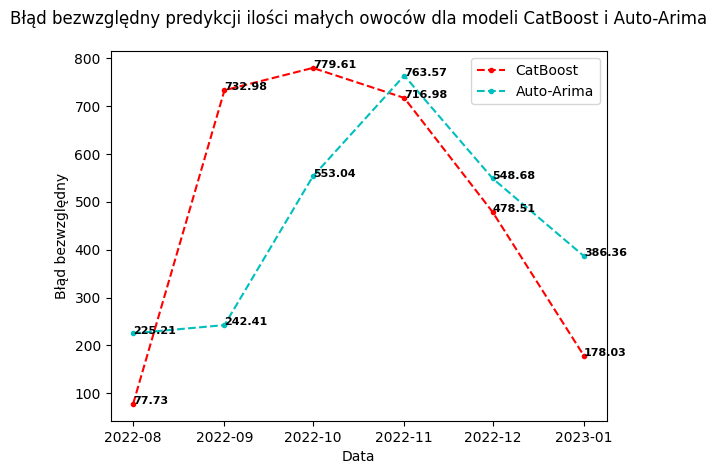

In [182]:
plt.plot(comparison_data_grouped["catboost_error_Tiny+Small"], 'r.--', label="CatBoost")
plt.plot(comparison_data_grouped["arima_error_Tiny+Small"], 'c.--', label="Auto-Arima")
# for x, y in zip(comparison_data_grouped["catboost_error_Tiny+Small"].values, comparison_data_grouped["arima_error_Tiny+Small"].values):
#     plt.text(x, y, f"({x}, {y})", fontsize=8)
for index in range(6):
    plt.text(comparison_data_grouped.index[index], round(comparison_data_grouped["arima_error_Tiny+Small"].values[index], 2),  round(comparison_data_grouped["arima_error_Tiny+Small"].values[index], 2), size=8, weight='bold')
    plt.text(comparison_data_grouped.index[index], round(comparison_data_grouped["catboost_error_Tiny+Small"].values[index], 2),  round(comparison_data_grouped["catboost_error_Tiny+Small"].values[index], 2), size=8, weight='bold')
plt.title("Błąd bezwzględny predykcji ilości małych owoców dla modeli CatBoost i Auto-Arima", y=1.05)
plt.xlabel("Data")
plt.ylabel("Błąd bezwzględny")
plt.legend()
plt.show()

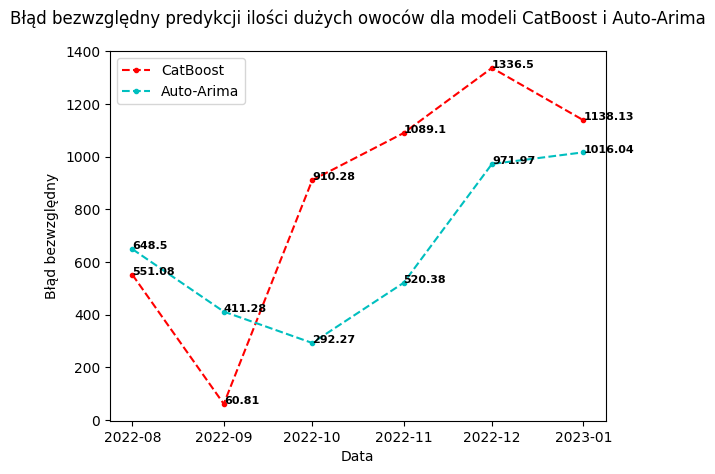

In [184]:
plt.plot(comparison_data_grouped["catboost_error_Large+Mature"], 'r.--', label="CatBoost")
plt.plot(comparison_data_grouped["arima_error_Large+Mature"], 'c.--', label="Auto-Arima")
for index in range(6):
    plt.text(comparison_data_grouped.index[index], round(comparison_data_grouped["arima_error_Large+Mature"].values[index], 2),  round(comparison_data_grouped["arima_error_Large+Mature"].values[index], 2), size=8, weight='bold')
    plt.text(comparison_data_grouped.index[index], round(comparison_data_grouped["catboost_error_Large+Mature"].values[index], 2),  round(comparison_data_grouped["catboost_error_Large+Mature"].values[index], 2), size=8, weight='bold')
plt.title("Błąd bezwzględny predykcji ilości dużych owoców dla modeli CatBoost i Auto-Arima", y=1.05)
plt.xlabel("Data")
plt.ylabel("Błąd bezwzględny")
plt.legend()
plt.show()